# Supervised learning - a short primer

This notebook covers some basic supervised learning techniques, which can be used in microbiome science.

The following methods can be used to find features (for example ASVs) that can predict some outcome of interest, for example whether a sample comes from a control or treatment group, or some other metadata associated with the samples. In some sense, the methods have the same outcome as in [Differential abundance analysis](https://microucph.github.io/amplicon_data_analysis/html/da.html), but with supervised machine learning the purpose is not of inference (based on p-values), but it is prediction. 

**Getting in-depth:**
If you want to learn more about machine learning I can highly recommend [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf) by Hastie, Tibshirani, and Friedman.

**Short primers:**
* [Paper on machine learning in general](https://www.nature.com/articles/nmeth.4526)
* [Paper on supervised learning](https://www.nature.com/articles/nmeth.4551)
* [Paper on statistics versus machine learning](https://www.nature.com/articles/nmeth.4642)

## Dataset<a class="anchor" id="data"></a>

Let's load our example dataset

In [1]:
library(phyloseq)
load("../data/physeq.RData")

## Train, validate, and test<a class="anchor" id="train"></a>
To ensure our model is not overfitting (having a good fit in our dataset, but cannot be generalized to other similar datasets), we need to split our dataset into 3 parts to ensure proper fitting. The **train** set of the dataset is used to train a specific model, the **validation** set is used compare models to choose hyperparameters of the model, and the **test** set is used only to check how good our final model works.

### Cross-validation
A widely used method for choosing hyperparameters is to use cross-validation. With cross-validation the train and validation datasets are combined and are split into k parts. Then the model is fit k times using a different part of the dataset each time as validation set, and the remainder as train set.

### To use a test set or not
If you want to know how good your model is, you should use a test set which has not been used for training at all. It's actually uncommon to see a test set in microbiome science, but because it is best practice we will use it in this notebook

**[In-depth paper on overfitting](https://www.nature.com/articles/nmeth.3968)**

In [2]:
# Split in test and train/validate (30 random samples are used a test set)
set.seed(42)
test_set <- sample(sample_names(phy), 30)

In [3]:
phy_train <- subset_samples(phy, !sample_names(phy) %in% test_set)
phy_test <- subset_samples(phy, sample_names(phy) %in% test_set)

In [4]:
phy_train

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1310 taxa and 120 samples ]
sample_data() Sample Data:       [ 120 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 1310 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1310 tips and 1309 internal nodes ]
refseq()      DNAStringSet:      [ 1310 reference sequences ]

In [5]:
phy_test

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1310 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 1310 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1310 tips and 1309 internal nodes ]
refseq()      DNAStringSet:      [ 1310 reference sequences ]

## Sparse regularized linear models<a class="anchor" id="lasso"></a>
A simple supervised learning method would be to use multiple linear regression, and simply add all features as independent variables. However, the problem with microbiome datasets is that we usually have many more features than samples (p > n problem), which means we cannot fit these models. A way to fix this problem is to use sparse regularization; the idea is that we penalize the model when it adds features, meaning that we try to force the model to only use features that are *important* enough for the prediction. 

**[In-depth paper on regularization](https://www.nature.com/articles/nmeth.4014)**

### L1 - LASSO
L1 penalty or LASSO, is a penalty which sets the estimates of "non-important" features to zero, that is, it selectes which features are most important for predicting the outcome. If there are highly correlating features, it will choose randomly among these.

### L2 - Ridge
L2 penalty or Ridge, is a penalty which reduces the estimates of all features as more features are added. It will therefore not select features (most estimates will be non-zero), but it will regularize the model. It is better fitted than LASSO if highly correlated features are included in the model

### Elastic net
Elastic net is a generalized penalty which introduces an *alpha* parameter. When *alpha=1* it is a LASSO penalty, when *alpha=0* it is Ridge, and with *alpha* between 0 and 1 it is a mix of the two.

### Hyperparameters
All these sparse regularization methods needs a *lamda* hyperparameter, which controls how strong the penalty is. Elastic net additionally needs the *alpha* hyperparameter.

### In R:

Let's fit a LASSO model. We use logistic regression as we want to predict whether our sample comes from a child which has been born by C-section (1) or vaginal birth (0).

**[In-depth paper on logistic regression](https://www.nature.com/articles/nmeth.3904)**

In [6]:
library(glmnet)

Indlæser krævet pakke: Matrix

Loaded glmnet 4.1-2



In [7]:
# Extract outcome and make it binary
y <- ifelse(unlist(sample_data(phy_train)[,"Delivery"]) == "Sectio", 1, 0)

# Extract features and normalize and transform them
X <- otu_table(phy_train)
X <- apply(X, 2, function(x) x+1/sum(x+1))
X <- t(log10(X))

**Note on transformation:** As the model assume linearity we log-transform the relative abundances to make them more *normal*. Alternatively, one could do a CLR transformation of the abundances.

Fit the model (with 5 cross-validation folds, 5-10 are usually recommended)

In [8]:
cvfit <- cv.glmnet(X, y, family = "binomial", alpha = 1, nfolds = 5)

We can plot the lambda parameter against the deviance. Low deviance means it's a good fit.

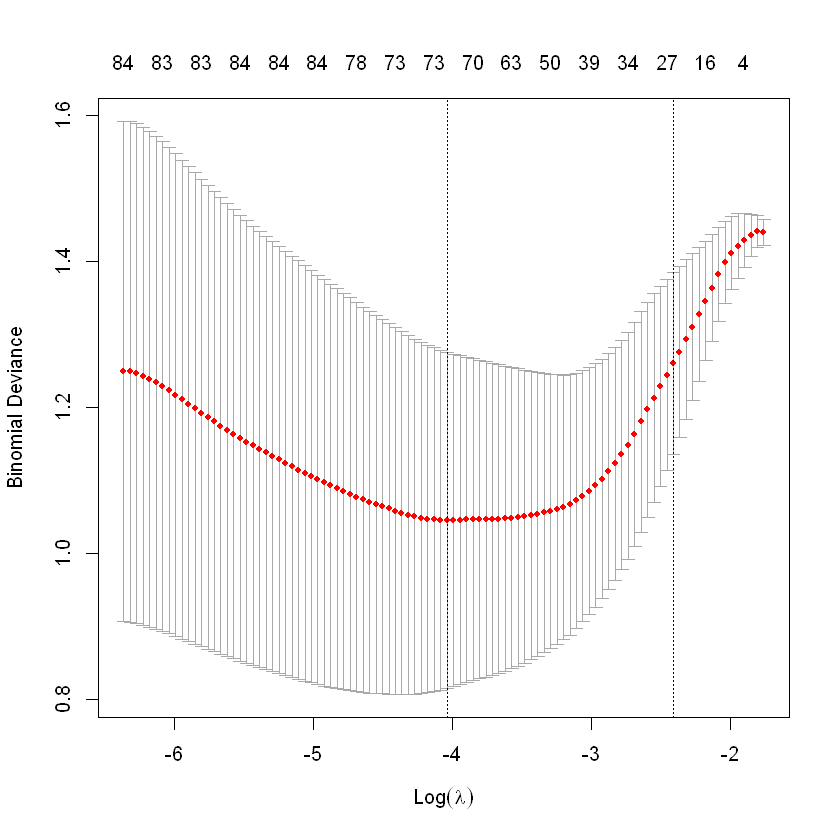

In [9]:
plot(cvfit)

If we start reading the plot from the left, we have many features in the model (84), as lambda increases (moving to the right), we get fewer features and the deviance is getting smaller. At some point the deviance starts rising again as we get even fewer features. The first vertical line denotes the best model (lowest deviance), the second vertical line denotes the simplest model of which the deviance is within 1 standard error of the mean of the best model. 

### Why is the deviance curve U-shaped?
With few features in the model (high lambda, right in the plot) we simply don't have enough information to make good predictions. With many features (low lambda, left in the plot) we start overfitting; features are added that only contributes variance to the model, so they might correlate with the outcome in the training set, but not in the validation set, and are therefore probably noise. So the sweet spot is somewhere inbetween - the lowest point in the U. If the curve is not U-shaped you might have specified the model incorretly or there is simply no signal in the data.

Let's see the coefficients of the simplest (but still good) model:

In [10]:
all_1se <- as.matrix(coef(cvfit, s = "lambda.1se"))
chosen_1se <- all_1se[all_1se > 0, ]
chosen_1se

(Intercept) 2424186d5cc0b7c749f3645004df6a17 
                    1.4910071986                     0.0653777788 
e19d099ae7e7587eaa48af0f58917a0f 1f685887ffe789e817d581f37aa3cfab 
                    0.0585232901                     0.0465210763 
43f3f2e3459e11bed9c3b5c187767fcf d4f4f46ec402280ae29751a0c0029f51 
                    0.0179657538                     0.0710826618 
7bc7407c94d7043a80982998cbac426d 01afdaa62d29c7baa9d60216b0ea90c1 
                    0.0269666263                     0.0249499682 
aa0d9eb04bfc40cf6079830cf147dea2 b411bdf72ff49585b1b1d6058244f6ee 
                    0.0491571292                     0.1084378523 
eae785b902cef8893ff591183dfa4efd 9dece060ffcff93473a7023dcee0defd 
                    0.0630101250                     0.0382871318 
bb44afa4a4d1bf473bb3fa1c5427e8de 50d6182d5d321721f2d223d9757415e2 
                    0.0185049656                     0.0006167052 
c1cb63a49b75a357d6fa0766f159baa3 097c0e27d72b6830014897b90dd3f899 
                    0.0317236590                     0.0151250926

Get taxonomy of the chosen ones (the -1 removes the intercept):

In [11]:
tax_table(phy)[names(chosen_1se)[-1]]

,Kingdom,Phylum,Class,Order,Family,Genus,Species
2424186d5cc0b7c749f3645004df6a17,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Genus_Escherichia
e19d099ae7e7587eaa48af0f58917a0f,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Genus_Escherichia
1f685887ffe789e817d581f37aa3cfab,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Genus_Escherichia
43f3f2e3459e11bed9c3b5c187767fcf,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Sutterella,Sutterella_wadsworthensis(GB_GCA_000980335.1)
d4f4f46ec402280ae29751a0c0029f51,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Family_Enterobacteriaceae,Family_Enterobacteriaceae
7bc7407c94d7043a80982998cbac426d,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Family_Enterobacteriaceae,Family_Enterobacteriaceae
01afdaa62d29c7baa9d60216b0ea90c1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Family_Enterobacteriaceae,Family_Enterobacteriaceae
aa0d9eb04bfc40cf6079830cf147dea2,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Moraxella,Moraxella_catarrhalis(RS_GCF_000092265.1)
b411bdf72ff49585b1b1d6058244f6ee,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Barnesiellaceae,Barnesiella,Barnesiella_intestinihominis(GB_GCA_000980475.1)
eae785b902cef8893ff591183dfa4efd,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,Prevotella_buccae(RS_GCF_000162455.1)


Above we have our chosen features and associated estimates for the model. As glmnet by default is standardizing the features, the estimates can be compared directly, and the highest estimate (in absolute terms) can be said to be most important for the prediction. Positive estimates would mean that higher abundance results in increase odds of being in the 1 group (C-section) compared to the 0 group (vaginal birth), and *vice versa* for negative estimates. This a strength of linear models compared to for example decision trees (e.g. random forest) where the associations can be non-linear and therefore not necesarrily easily interpretable.


Let's check how good the model is on the test set

In [12]:
# Extract outcome and make it binary
y_test <- ifelse(unlist(sample_data(phy_test)[,"Delivery"]) == "Sectio", 1, 0)

# Extract features and normalize and transform them
X_test <- otu_table(phy_test)
X_test <- apply(X_test, 2, function(x) x+1/sum(x+1))
X_test <- t(log10(X_test))

In [13]:
table(y_test, predict(object = cvfit, s = "lambda.1se", newx = X_test, type = "class"))

      
y_test  0  1
     0 11  3
     1  4 12

The rows are the truths (test set) and the columns are the predicted. So of the 14 samples that were 0 (vaginal birth), 11 were correctly predicted as such and 3 were false predicted as 1 (C-section). Of the 16 samples that were 1 (C-section), 12 were correctly predicted as such and 4 were false predicted as 0 (vaginal birth). The accuracy is 77% ((11+12)/30).

Let's test our model on our train/validation set:

In [14]:
table(y, predict(object = cvfit, s = "lambda.1se", newx = X, type = "class"))

   
y    0  1
  0 57  4
  1  3 56

Now the accuracy is 94%. So we can see that the accuracy becomes falsely inflated if we were to test it on the same dataset as we used to training.

For more details on sparse regularized linear models, [see here](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html)

## Random forests<a class="anchor" id="rf"></a>
Random forests is a model based on an ensemble of decision trees based on bagging (bootstrap aggregating) and random subsets of the features.

### Decision tree
A decision tree is a type of model that splits the samples into groups (leaves on the tree) based on the features. For example, a simple tree could contain a single split such that samples in which an ASV is less abundant than 1% are in branch A and samples in which this ASV is more abundant than 1% are in branch B. The decision trees can have multiple splits, such that they are based on multiple features.
**[In-depth paper on decision trees](https://www.nature.com/articles/nmeth.4370)**

### Bootstrapping
With bootstrapping one does a random sampling with replacement of the samples. That is, instead of using the raw data as input to the model, the model randomly chooses the same number of samples, but some samples can be included more than one time (and some might be excluded). Bootstrapping is crucial, as without bootstrapping the trees would be highly similar (correlated), which would bias the final model.
**[In-depth paper in the bootstrap](https://www.nature.com/articles/nmeth.3414)**

### Random feature subset
To create more variation among the decision trees, only a random subset of features are used at each split. 

### In essence
Random forest is fitting multiple decision trees, each tree is trained on bootstrapped samples, and each split in the trees are using random subsets of the features. Each tree is actually a bad predictor, but aggregating a lot of trees will produce good predictions. For classification problems they are aggregated by majority vote, and for regression problems the aggregation is simply the mean predictions across all trees.
**[In-depth paper on bagging and random forest](https://www.nature.com/articles/nmeth.4438)**

### Hyperparameters
There are 2 main hyperparameters for random forests, the number of trees, and the number of randomly chosen features at each split (AKA mtry). The last one has some widely used recommendations; sqrt(n_features) for classification problems and n_features/3 for regression problems. As for the number of trees, a few hundred usually works well, but this number could also be tuned through cross-validation.

### In R:
Below we simply use the default parameters for random forest, and we therefore only have a training and test set.

In [15]:
library(randomForest)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.



In [16]:
fit <- randomForest(y = factor(y), x = X, 
                    ytest = factor(y_test), xtest = X_test, 
                    importance = TRUE)

In [17]:
fit


Call:
 randomForest(x = X, y = factor(y), xtest = X_test, ytest = factor(y_test),      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 36

        OOB estimate of  error rate: 33.33%
Confusion matrix:
   0  1 class.error
0 47 14   0.2295082
1 26 33   0.4406780
                Test set error rate: 26.67%
Confusion matrix:
   0  1 class.error
0 10  4   0.2857143
1  4 12   0.2500000

So the model has a test accuracy of 73%, a little worse than the LASSO linear model used above. The OOB estimate of error rate means Out-Of-Bag, and is using the samples not included by the bootstrap procedure as a validation set.

We can see which features are important for the model. MeanDecreaseAccuracy is the decrease in accuracy if this features was removed from the model, thus a high value means the feature is important:

In [18]:
fit$importance[rev(order(fit$importance[, "MeanDecreaseAccuracy"])), ]

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
50d6182d5d321721f2d223d9757415e2,0.0051121646,0.0090025025,0.006967982,0.9682275
7bc7407c94d7043a80982998cbac426d,0.0044255706,0.0039640536,0.004135349,0.5744608
c1cb63a49b75a357d6fa0766f159baa3,0.0020595914,0.0054573756,0.003698760,0.5236623
45c4f6f269ec95ff0c8dd594104519e9,0.0044879250,0.0023865451,0.003621151,0.6068007
d20d3658de331c939f54d8acaed7c4c1,0.0005296290,0.0057009904,0.003129186,0.5987402
ca5152dd2313e7fe7d25872f10c57f6d,0.0019553035,0.0041834328,0.003089687,0.5076726
eae785b902cef8893ff591183dfa4efd,0.0015453908,0.0039137051,0.002698606,0.3370282
d44ac2ef51574f366f2223bb95cde111,0.0016763331,0.0037300994,0.002644548,0.5763823
ccc3cce7144df93b827dc9a9fd18dfaf,0.0021739613,0.0031685122,0.002562180,0.4822958
aa0d9eb04bfc40cf6079830cf147dea2,0.0019777643,0.0025166883,0.002168577,0.2161084


We can merge this with the taxonomy:

In [19]:
tax <- data.frame(tax_table(phy))
imp <- fit$importance
imp_tax <- merge(imp, tax, by = "row.names")
imp_tax[rev(order(imp_tax$MeanDecreaseAccuracy)), ]

,Row.names,0,1,MeanDecreaseAccuracy,MeanDecreaseGini,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
415,50d6182d5d321721f2d223d9757415e2,0.0051121646,0.0090025025,0.006967982,0.9682275,Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Veillonellaceae,Veillonella,Veillonella_dispar(RS_GCF_000160015.1)
628,7bc7407c94d7043a80982998cbac426d,0.0044255706,0.0039640536,0.004135349,0.5744608,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Family_Enterobacteriaceae,Family_Enterobacteriaceae
973,c1cb63a49b75a357d6fa0766f159baa3,0.0020595914,0.0054573756,0.003698760,0.5236623,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides_eggerthii(RS_GCF_000273465.1)
362,45c4f6f269ec95ff0c8dd594104519e9,0.0044879250,0.0023865451,0.003621151,0.6068007,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Citrobacter,Genus_Citrobacter
1055,d20d3658de331c939f54d8acaed7c4c1,0.0005296290,0.0057009904,0.003129186,0.5987402,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Genus_Bacteroides
1010,ca5152dd2313e7fe7d25872f10c57f6d,0.0019553035,0.0041834328,0.003089687,0.5076726,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus_B,Lactobacillus_B_ruminis(RS_GCF_001436475.1)
1182,eae785b902cef8893ff591183dfa4efd,0.0015453908,0.0039137051,0.002698606,0.3370282,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,Prevotella_buccae(RS_GCF_000162455.1)
1068,d44ac2ef51574f366f2223bb95cde111,0.0016763331,0.0037300994,0.002644548,0.5763823,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides_rodentium(GB_GCA_000614125.1)
1018,ccc3cce7144df93b827dc9a9fd18dfaf,0.0021739613,0.0031685122,0.002562180,0.4822958,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus_C,Lactobacillus_C_casei(RS_GCF_000829055.1)
